In [25]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn
import mne
from mne.viz import plot_topomap
import os
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split, cross_val_score,StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from mne.datasets import sample
from mne.decoding import (
    CSP,
    GeneralizingEstimator,
    LinearModel,
    Scaler,
    SlidingEstimator,
    Vectorizer,
    cross_val_multiscore,
    get_coef,
)

from scipy.stats import ttest_1samp
from statsmodels.stats.multitest import multipletests

# some metadata
SNRs = np.array([-np.inf,-13,-11,-9,-7,-5,-3])
SubIDs = ['01','02','03','05','06','07','08','09','11','12','13','14','15','17','19','20','22','23','24','25']
colormap = {0: (0, 0, 0), 1: (0, 0.25, 1), 2: (0, 0.9375, 1), 3: (0, 0.91, 0.1), 4: (1, 0.6, 0), 5: (1, 0, 0), 6: (0.8, 0, 0)}

print(os.getcwd())

/srv/elefanto/ConsciousnessTeam_Data/SOUNDMODEL


In [131]:
part = 18

# 1: Reproducing classical TempGen

In [64]:
def plot_TG_matrix(time_series, cat, baseline_correction=True, save_path=None):
    tgmatrix = np.mean(time_series[cat], 0)
    baseline = np.mean(time_series[0], 0) if baseline_correction else np.zeros(np.shape(time_series[0][0]))
    plt.figure()
    plt.imshow(tgmatrix[30:200,30:200] - baseline[30:200,30:200], aspect='equal', cmap="RdBu_r", origin='lower', extent=[-200, 1500, -200, 1500])
    plt.xlabel('Application time (ms)')
    plt.ylabel('Training time (ms)')
    plt.colorbar(label='AVG predictor')
    plt.title(f'Temporal Generalisation, cat {cat}')
    plt.savefig(save_path) if save_path != None else None
    plt.show()

Reading /srv/elefanto/ConsciousnessTeam_Data/SOUNDMODEL/Data_SoundGOOD/myEpochs_Passive/Epoch_24-epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1998.00 ms
        0 CTF compensation matrices available
Adding metadata with 6 columns
999 matching events found
No baseline correction applied
0 projection items activated


/tmp/ipykernel_1505642/1062549200.py:2: RuntimeWarning: The measurement information indicates a low-pass frequency of 250.0 Hz. The decim=5 parameter will result in a sampling frequency of 100.0 Hz, which can cause aliasing artifacts.
  epochs = mne.read_epochs(data_ref, preload=True).decimate(5)


Fit...
Applies to data...


  0%|          | 0/6 [00:00<?, ?it/s]

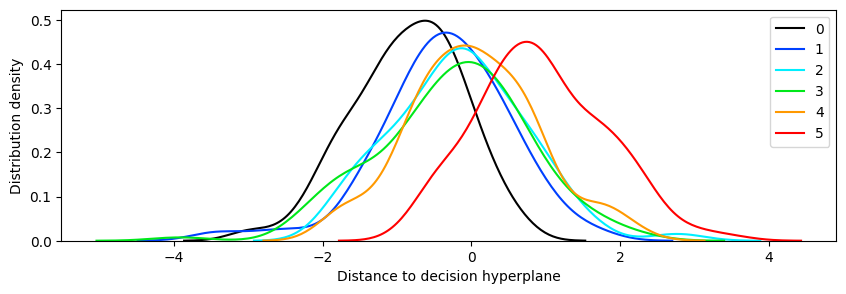

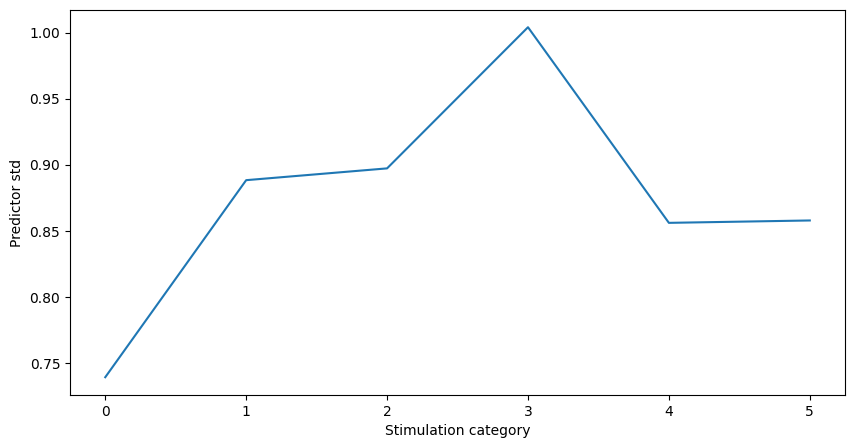

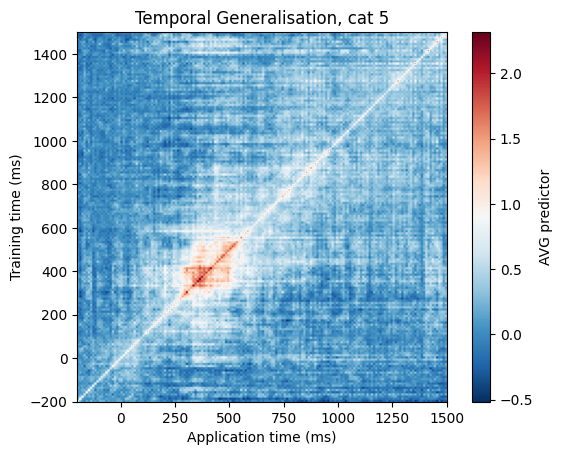

In [132]:
data_ref = 'Data_SoundGOOD/myEpochs_Passive/Epoch_'+SubIDs[part]+'-epo.fif'
epochs = mne.read_epochs(data_ref, preload=True).decimate(5)

stim_pres_epochs = epochs['6']
stim_abs_epochs = epochs['1']
combined_epochs = mne.concatenate_epochs([stim_abs_epochs, stim_pres_epochs], verbose=False)

X = combined_epochs.get_data()  # Shape: (n_epochs, n_channels, n_times)
y = np.where(combined_epochs.events[:, 2] == 1, 0, 1)

clf = make_pipeline(
    Scaler(combined_epochs.info, scalings='mean'),
    Vectorizer(),
     LinearModel(LogisticRegression(penalty='l2', solver="liblinear")),  # liblinear is faster than lbfgs
)

# define the Temporal generalization object
time_gen = GeneralizingEstimator(clf, n_jobs=10, scoring="roc_auc", verbose=False)

# fit and output distance to the decision hyperplane
print('Fit...')
time_gen.fit(X,y)

time_series = {}

# distributions
print('Applies to data...')
stds = []
plt.figure(figsize=(10,3))
for cat in tqdm(range(6)):
    preds = time_gen.decision_function(epochs[str(cat+1)].get_data())
    time_series[cat] = preds
    # np.save(f'TemporalGeneralization/TG_C{i}_{field}_{cat[-4:]}_AllTrials.npy', preds)
    # preds_slice = np.mean(preds[:,95:105,:],-2)
    # preds_square = -np.mean(preds_slice[:,90:100], 1)
    preds_diag = np.array([np.mean(np.diag(trial[90:100,90:100])) for trial in preds])
    stds.append(np.std(preds_diag))
    seaborn.kdeplot(data=preds_diag,label=str(cat),color=colormap[cat])
plt.xlabel('Distance to decision hyperplane')
plt.ylabel('Distribution density')
plt.legend()
# plt.title(f'Distribution of decoding scores between 448 and 547 ms post-stim, C{i}, {field}.')
# plt.savefig(f'BifurcationDistributions/C{i}_{field}_448to547ms.png')
plt.show()

# stds
# stds_all_parts.append(stds)
plt.figure(figsize=(10,5))
plt.plot([0,1,2,3,4,5], stds)
plt.xlabel('Stimulation category')
plt.ylabel('Predictor std')
# plt.title(f'STD of decoding scores between 448 and 547 ms post-stim, C{i}, {field}.')
# plt.savefig(f'BifurcationDistributions/C{i}_{field}_448to547ms_stds.png')
plt.show()


# plot TG matrix
plot_TG_matrix(time_series, cat=5)

[5, 5]


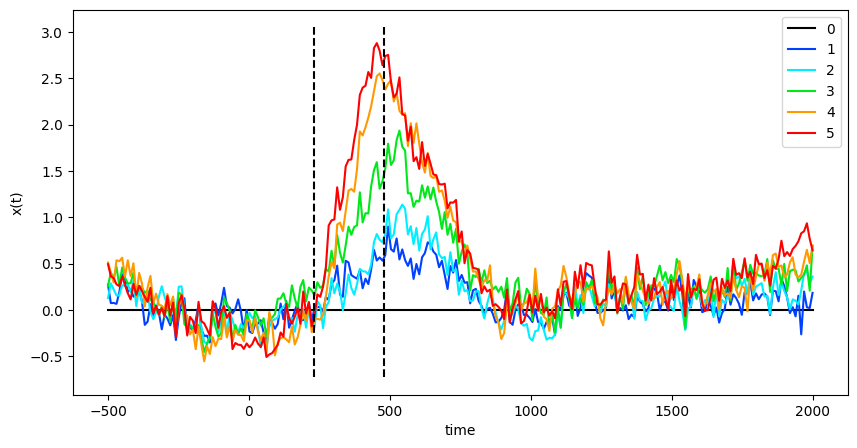

In [27]:
# plot trajectories
def plot_phase_trajectories(time_series, trials, training_time=None, avg=False, SGfilter=False, compare=False, cursor=None, save_path=None, train_steps=[5,5]):
    '''
    - "trials" is a dict with categories as keys and trial arrays as elements.
    Ex : trials = {0 : [0, 1, 2], 5 : [0, 1, 2, 3, 4]}.
    - "compare" is True for comparing filtered and not filtered trajectories.
    '''
    nb_timepoints = len(time_series[list(time_series.keys())[0]][0,training_time]) if training_time != None else len(time_series[list(time_series.keys())[0]][0])
    times = np.linspace(-500, 2000, nb_timepoints)
    categories = time_series.keys()
    print(train_steps)
    time_series = {cat : np.mean(time_series[cat][:,training_time-train_steps[0]:training_time+train_steps[1],:],-2) for cat in categories} if training_time != None else time_series
    plt.figure(figsize=(10,5))
    for cat in trials.keys() :
        plt.plot(times, np.mean(time_series[cat],0),color=colormap[cat],label=str(cat)) if avg and not(SGfilter) else None
        if SGfilter and avg :
            all_filtered = scipy.signal.savgol_filter(time_series[cat], window_length=wl, polyorder=po, deriv=0, axis=-1)
            plt.plot(times, np.mean(all_filtered,0),color=colormap[cat],label=str(cat))
        for traj_nb in trials[cat] :
            if SGfilter :
                plt.plot(times, time_series[cat][traj_nb], color='gray', linestyle=None) if compare else None
                filtered = scipy.signal.savgol_filter(time_series[cat][traj_nb], window_length=wl, polyorder=po, deriv=0, axis=-1)
                plt.plot(times, filtered, linestyle=':' if avg else None, color=colormap[cat] if len(list(trials.keys()))>1 else None)
            else :
                plt.plot(times, time_series[cat][traj_nb], linestyle=':' if avg else None, color=colormap[cat] if len(list(trials.keys()))>1 else None)
    if cursor != None:
        xmin, xmax = plt.ylim()
        for value in cursor : 
            plt.plot([value, value], [xmin, xmax], linestyle='--', color='black')
    plt.xlabel('time')
    plt.ylabel('x(t)')
    plt.legend()
    plt.savefig(save_path) if save_path != None else None
    plt.show()


time_series_bc = {cat: time_series[cat] - np.mean(time_series[0],0) for cat in time_series.keys()}
plot_phase_trajectories(time_series_bc, trials={0 : [], 1 : [], 2 : [], 3 : [], 4 : [], 5 : []}, training_time=100, avg=True, SGfilter=False, compare=False, cursor=[480, 230],
                                save_path=None)

# 2: Discrete Temporal Generalization

## 2.1: Defining the late process time window from the classical TG matrix

Z.shape = (250, 250)


  0%|          | 0/676 [00:00<?, ?it/s]

Best params : (np.int64(68), np.float64(2.9899908945071783), np.int64(87), np.float64(9.274711083757902)), hence best times : (np.int64(370), np.int64(180)) ms pso.


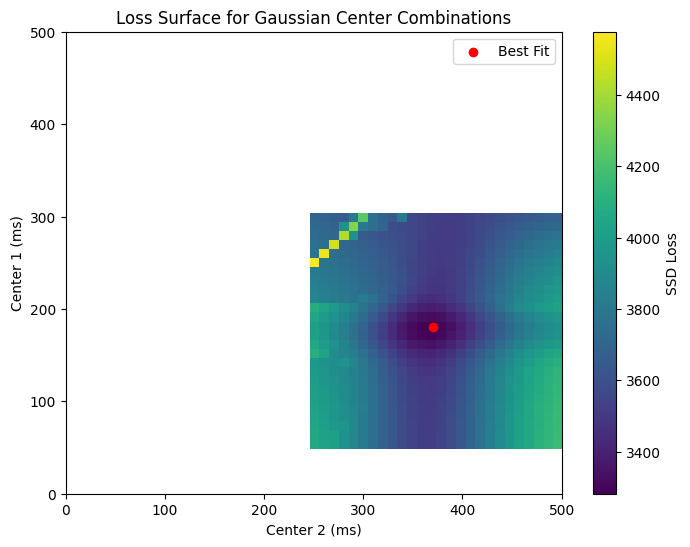

In [103]:
from scipy.optimize import minimize
from itertools import product

# TG matrix for category 5
Z = np.mean(time_series[5], 0) - np.mean(time_series[0], 0)
print(f'Z.shape = {Z.shape}')

def gaussian_2d(X, Y, xc, sigma):
    return np.exp(-((X - xc)**2 + (Y - xc)**2) / (2 * sigma**2))

def model_fit(params, X, Y, Z, centers):
    sigma1, sigma2 = params
    G1 = gaussian_2d(X, Y, centers[0], sigma1)
    G2 = gaussian_2d(X, Y, centers[1], sigma2)
    
    # Estimate amplitudes via least squares
    G_stack = np.stack([G1.ravel(), G2.ravel()], axis=1)
    A, _, _, _ = np.linalg.lstsq(G_stack, Z.ravel(), rcond=None)
    
    Z_pred = A[0] * G1 + A[1] * G2
    return np.sum((Z - Z_pred)**2)

def fit_gaussians(Z, x1_range, x2_range, sigma_bounds=(1, 30)):
    H, W = Z.shape
    X, Y = np.meshgrid(np.arange(W), np.arange(H))

    score_matrix = np.full((51, 51), np.inf)
    best_loss = np.inf
    best_params = None

    for x1, x2 in tqdm(product(x1_range, x2_range), total=676):
        res = minimize(
            model_fit,
            x0=[5.0, 5.0],
            args=(X, Y, Z, (x1, x2)),
            bounds=[sigma_bounds, sigma_bounds]
        )
        score_matrix[x1-50, x2-50] = res.fun
        if res.fun < best_loss:
            best_loss = res.fun
            best_params = (x1, res.x[0], x2, res.x[1])

    return best_params, score_matrix


x1_range, x2_range = np.arange(55,81), np.arange(75,101)
best_params, score_matrix = fit_gaussians(Z, x1_range, x2_range, sigma_bounds=(1, 30))
print(f'Best params : {best_params}, hence best times : {best_params[2]*10-500, best_params[0]*10-500} ms pso.')

plt.figure(figsize=(8, 6))
plt.imshow(score_matrix, extent=[0, 500, 0, 500],
           aspect='auto', origin='lower', cmap='viridis')
plt.colorbar(label='SSD Loss')
plt.xlabel('Center 2 (ms)')
plt.ylabel('Center 1 (ms)')
plt.title('Loss Surface for Gaussian Center Combinations')
plt.scatter(best_params[2]*10-500, best_params[0]*10-500, color='red', label='Best Fit')
plt.legend()
plt.show()

In [92]:
import matplotlib.patches as patches

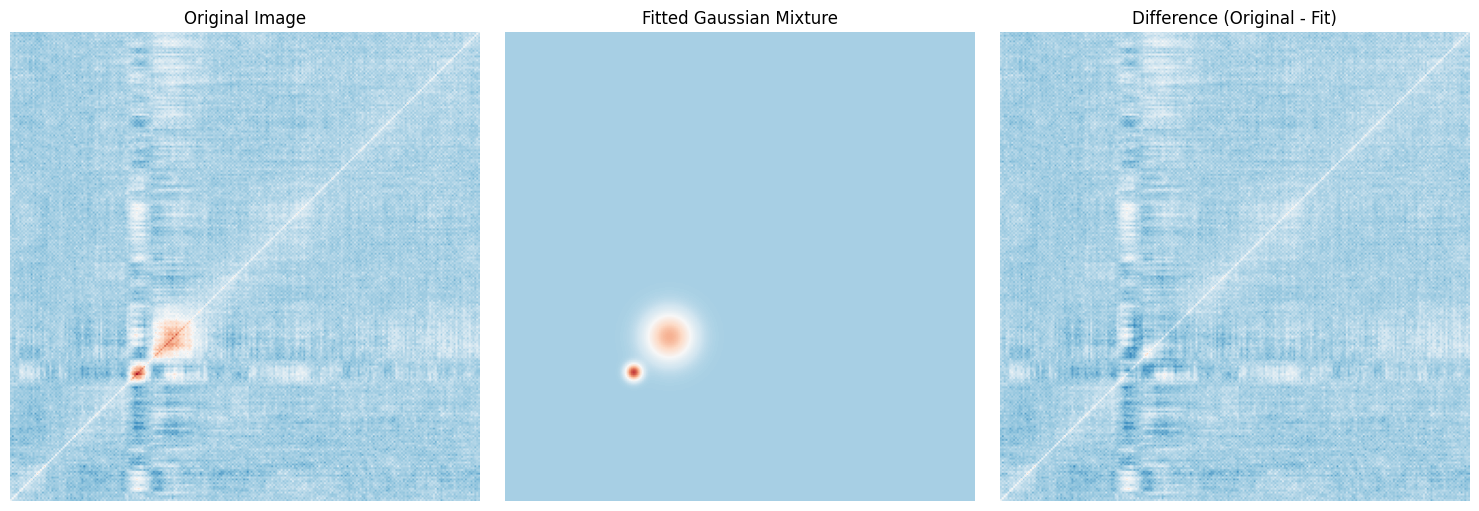

In [102]:
def generate_gmm_image(X, Y, Z, x1, sigma1, x2, sigma2):
    G1 = gaussian_2d(X, Y, x1, sigma1)
    G2 = gaussian_2d(X, Y, x2, sigma2)
    
    # Solve for amplitudes A1, A2 using least squares
    G_stack = np.stack([G1.ravel(), G2.ravel()], axis=1)
    A, _, _, _ = np.linalg.lstsq(G_stack, Z.ravel(), rcond=None)
    
    Z_model = A[0] * G1 + A[1] * G2
    return Z_model, A


H, W = Z.shape
X, Y = np.meshgrid(np.arange(W), np.arange(H))

x1, sigma1, x2, sigma2 = best_params

Z_model, (A1, A2) = generate_gmm_image(X, Y, Z, x1, sigma1, x2, sigma2)

# ---- Plotting ----
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Original image
axes[0].imshow(Z, aspect='equal', cmap="RdBu_r", origin='lower', extent=[-500, 2000, -500, 2000], vmin=-2, vmax=4)
axes[0].set_title('Original Image')

# Fitted GMM
axes[1].imshow(Z_model, aspect='equal', cmap="RdBu_r", origin='lower', extent=[-500, 2000, -500, 2000], vmin=-2, vmax=4)
axes[1].set_title('Fitted Gaussian Mixture')

# Difference
diff = Z - Z_model
axes[2].imshow(diff, aspect='equal', cmap="RdBu_r", origin='lower', extent=[-500, 2000, -500, 2000], vmin=-2, vmax=4)
axes[2].set_title('Difference (Original - Fit)')

for ax in axes:
    ax.axis('off')

plt.tight_layout()
plt.show()

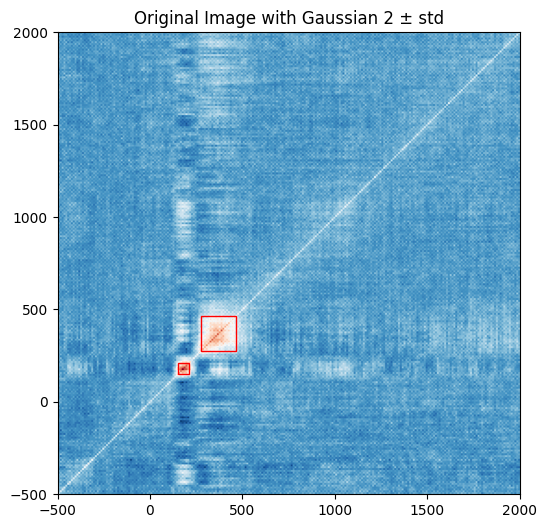

In [101]:
# Define the square bounds
best_times = [best_params[2]*10-500, best_params[0]*10-500]

side_length2 = 20 * sigma2
corner2 = (best_times[0] - sigma2*10, best_times[0] - sigma2*10)  # bottom-left corner

side_length1 = 20 * sigma1
corner1 = (best_times[1] - sigma1*10, best_times[1] - sigma1*10)  # bottom-left corner

# Plot the original image
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(Z, aspect='equal', cmap="RdBu_r", origin='lower', extent=[-500, 2000, -500, 2000])
ax.set_title('Original Image with Gaussian 2 ± std')

# Add square patches
rect1 = patches.Rectangle(
    corner1,
    side_length1,
    side_length1,
    linewidth=1,
    edgecolor='red',
    facecolor='none'
)
ax.add_patch(rect1)

rect2 = patches.Rectangle(
    corner2,
    side_length2,
    side_length2,
    linewidth=1,
    edgecolor='red',
    facecolor='none'
)
ax.add_patch(rect2)

plt.show()

## 2.2: Computing discrete Temporal Generalization

In [122]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import math

tmin, tmax = 277, 462 ms.


/tmp/ipykernel_1505642/65674977.py:6: RuntimeWarning: The measurement information indicates a low-pass frequency of 250.0 Hz. The decim=5 parameter will result in a sampling frequency of 100.0 Hz, which can cause aliasing artifacts.
  epochs = mne.read_epochs(data_ref, preload=True, verbose=False).decimate(5).crop(tmin=tmin/1000, tmax=tmax/1000, include_tmax=True, verbose=False)


Fit...
(64,)


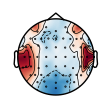

/tmp/ipykernel_1505642/65674977.py:44: RuntimeWarning: The measurement information indicates a low-pass frequency of 250.0 Hz. The decim=5 parameter will result in a sampling frequency of 100.0 Hz, which can cause aliasing artifacts.
  epochs = mne.read_epochs(data_ref, preload=True, verbose=False).decimate(5)


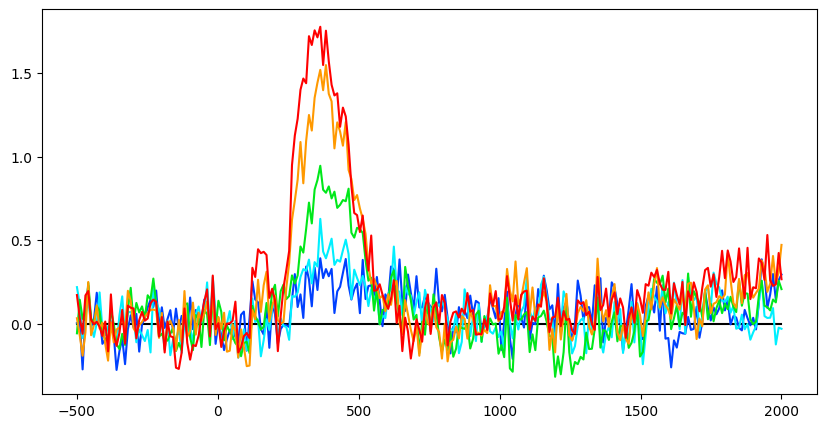

In [127]:
part = 13
data_ref = 'Data_SoundGOOD/myEpochs_Passive/Epoch_'+SubIDs[part]+'-epo.fif'
tmin = int(best_times[0] - sigma2*10)
tmax = int(best_times[0] + sigma2*10)
print(f'tmin, tmax = {tmin}, {tmax} ms.')
epochs = mne.read_epochs(data_ref, preload=True, verbose=False).decimate(5).crop(tmin=tmin/1000, tmax=tmax/1000, include_tmax=True, verbose=False)

stim_pres_epochs = epochs['6']
stim_abs_epochs = epochs['1']
combined_epochs = mne.concatenate_epochs([stim_abs_epochs, stim_pres_epochs], verbose=False)

X = combined_epochs.get_data().transpose(0, 2, 1)  # Shape: (n_epochs, n_times, n_channels)
y = np.repeat(np.where(combined_epochs.events[:, 2] == 1, 0, 1), X.shape[1])
X = X.reshape(-1, 64)  # Shape: (n_epochs*n_times, n_channels)

# Define the pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler(with_mean=True)),  # Center and scale
    ('classifier', LogisticRegression(solver='liblinear', penalty='l2'))
])


# fit and output distance to the decision hyperplane
print('Fit...')
pipeline.fit(X,y)
logreg_model = pipeline.named_steps['classifier']
weights = logreg_model.coef_
bias = logreg_model.intercept_


# compute activation pattern
cov_X = np.cov(X, rowvar=False)
w = weights.flatten()
pattern = cov_X @ w
print(pattern.shape)

# snapshot = epochs.crop(tmin=0.350, tmax=0.350, include_tmax=True)

# For binary classification: patterns[0] or patterns[1] (they’re usually negatives of each other)
plot_topomap(pattern, epochs.info, show=True)


# plot average predictors
epochs = mne.read_epochs(data_ref, preload=True, verbose=False).decimate(5)
time_series = {}
for cat in range(6):
    data = epochs[str(cat+1)].get_data()
    series = []
    for trial in data : 
        series.append(pipeline.decision_function(trial.T))
    series = np.array(series)
    time_series[cat] = series

time_series = {cat: time_series[cat] - np.mean(time_series[0],0) for cat in range(6)}
    
times = np.linspace(-500,2000,250)
plt.figure(figsize=(10,5))
for cat in range(6):
    plt.plot(times, np.mean(time_series[cat],0),color=colormap[cat])
plt.show()

tmin, tmax = 150, 209 ms.


/tmp/ipykernel_1505642/1757057083.py:6: RuntimeWarning: The measurement information indicates a low-pass frequency of 250.0 Hz. The decim=5 parameter will result in a sampling frequency of 100.0 Hz, which can cause aliasing artifacts.
  epochs = mne.read_epochs(data_ref, preload=True, verbose=False).decimate(5).crop(tmin=tmin/1000, tmax=tmax/1000, include_tmax=True, verbose=False)


Fit...
(64,)


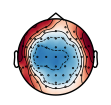

/tmp/ipykernel_1505642/1757057083.py:44: RuntimeWarning: The measurement information indicates a low-pass frequency of 250.0 Hz. The decim=5 parameter will result in a sampling frequency of 100.0 Hz, which can cause aliasing artifacts.
  epochs = mne.read_epochs(data_ref, preload=True, verbose=False).decimate(5)


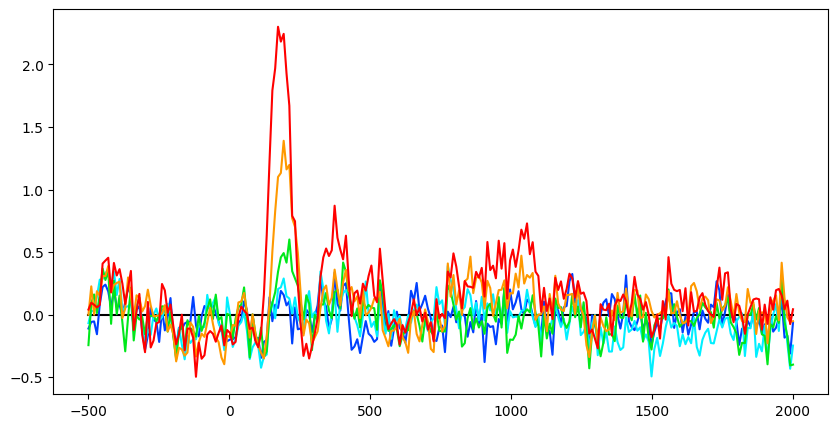

In [128]:
part = 13
data_ref = 'Data_SoundGOOD/myEpochs_Passive/Epoch_'+SubIDs[part]+'-epo.fif'
tmin = int(best_times[1] - sigma1*10)
tmax = int(best_times[1] + sigma1*10)
print(f'tmin, tmax = {tmin}, {tmax} ms.')
epochs = mne.read_epochs(data_ref, preload=True, verbose=False).decimate(5).crop(tmin=tmin/1000, tmax=tmax/1000, include_tmax=True, verbose=False)

stim_pres_epochs = epochs['6']
stim_abs_epochs = epochs['1']
combined_epochs = mne.concatenate_epochs([stim_abs_epochs, stim_pres_epochs], verbose=False)

X = combined_epochs.get_data().transpose(0, 2, 1)  # Shape: (n_epochs, n_times, n_channels)
y = np.repeat(np.where(combined_epochs.events[:, 2] == 1, 0, 1), X.shape[1])
X = X.reshape(-1, 64)  # Shape: (n_epochs*n_times, n_channels)

# Define the pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler(with_mean=True)),  # Center and scale
    ('classifier', LogisticRegression(solver='liblinear', penalty='l2'))
])


# fit and output distance to the decision hyperplane
print('Fit...')
pipeline.fit(X,y)
logreg_model = pipeline.named_steps['classifier']
weights = logreg_model.coef_
bias = logreg_model.intercept_


# compute activation pattern
cov_X = np.cov(X, rowvar=False)
w = weights.flatten()
pattern = cov_X @ w
print(pattern.shape)

# snapshot = epochs.crop(tmin=0.350, tmax=0.350, include_tmax=True)

# For binary classification: patterns[0] or patterns[1] (they’re usually negatives of each other)
plot_topomap(pattern, epochs.info, show=True)


# plot average predictors
epochs = mne.read_epochs(data_ref, preload=True, verbose=False).decimate(5)
time_series = {}
for cat in range(6):
    data = epochs[str(cat+1)].get_data()
    series = []
    for trial in data : 
        series.append(pipeline.decision_function(trial.T))
    series = np.array(series)
    time_series[cat] = series

time_series = {cat: time_series[cat] - np.mean(time_series[0],0) for cat in range(6)}
    
times = np.linspace(-500,2000,250)
plt.figure(figsize=(10,5))
for cat in range(6):
    plt.plot(times, np.mean(time_series[cat],0),color=colormap[cat])
plt.show()